# More Forex Analysis

In [1]:
import hotstepper as hs
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

Get some data from the trusty hotstepper-data repository

In [2]:
df_gbpaud = pd.read_csv('https://raw.githubusercontent.com/TangleSpace/hotstepper-data/master/data/forex/GBPAUD_H1.csv',delimiter='\t',parse_dates=['Time'])
df_audusd = pd.read_csv('https://raw.githubusercontent.com/TangleSpace/hotstepper-data/master/data/forex/AUDUSD_H1.csv',delimiter='\t',parse_dates=['Time'])
df_gbpusd = pd.read_csv('https://raw.githubusercontent.com/TangleSpace/hotstepper-data/master/data/forex/GBPUSD_H1.csv',delimiter='\t',parse_dates=['Time'])


In [3]:
df_gbpusd.head()

,Time,Open,High,Low,Close,Volume
0,2013-01-28 10:00:00,1.57474,1.57475,1.57243,1.57243,8337
1,2013-01-28 11:00:00,1.57245,1.57263,1.57050,1.57050,8119
2,2013-01-28 12:00:00,1.57049,1.57329,1.57049,1.57257,11026
3,2013-01-28 13:00:00,1.57256,1.57389,1.57102,1.57366,11717
4,2013-01-28 14:00:00,1.57366,1.57431,1.57133,1.57171,11911


Hotstepper can deal with regular datasets by performing a delta conversion (convert_delta=True) when loading the data, this way, a regular dataset is transformed into a series of steps that provide all the convenience available from being a Steps object. In this case, we have loaded 3 forex 1 hour data sets spanning 10 years, we can have a quick look and create a smooth plot all with little effort.

<AxesSubplot:title={'center':'GBPUSD Close'}>

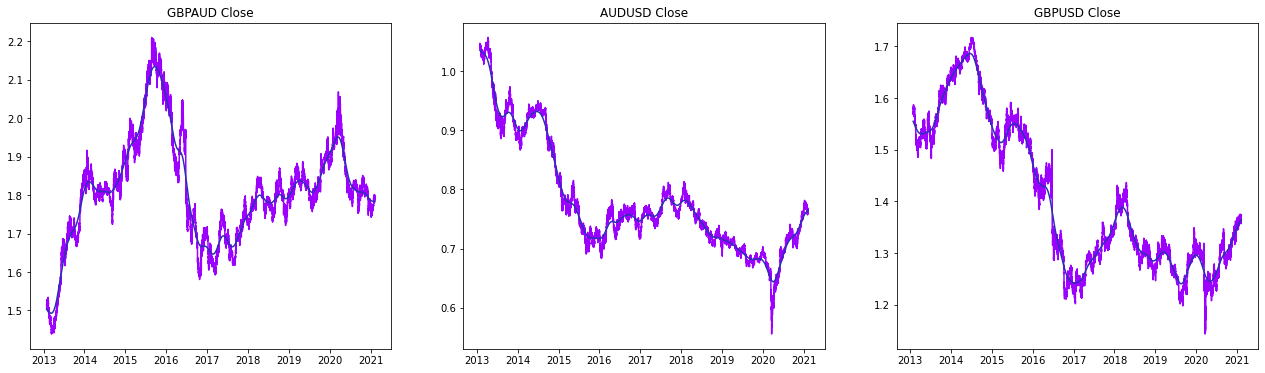

In [4]:
fig,ax = plt.subplots(ncols=3,figsize=(22,6))

gbpaud_close = hs.Steps.read_dataframe(df_gbpaud,start='Time', weight='Close',convert_delta=True)
audusd_close = hs.Steps.read_dataframe(df_audusd,start='Time', weight='Close',convert_delta=True)
gbpusd_close = hs.Steps.read_dataframe(df_gbpusd,start='Time', weight='Close',convert_delta=True)

ax[0].set_title('GBPAUD Close')
gbpaud_close.plot(ax=ax[0])
gbpaud_close.smooth_plot(ax=ax[0])

ax[1].set_title('AUDUSD Close')
audusd_close.plot(ax=ax[1])
audusd_close.smooth_plot(ax=ax[1])

ax[2].set_title('GBPUSD Close')
gbpusd_close.plot(ax=ax[2])
gbpusd_close.smooth_plot(ax=ax[2])


Now for an interesting manipulation, in forex, currencys prices represent the conversion price for the pairs, for example, GBPAUD represents how many AUD (Australian dollars) are needed to buy 1 GBP (Great British Pound). You can also think of this like a ratio, $price=\frac{GBP}{AUD}$.

Now, since it is a ratio, we could use some simple manipulations to find the price of another pair, for example $\frac{GBP}{USD}$ and $\frac{AUD}{USD}$. If we divide these and use the rules of simple algebra, we have $price=\frac{\frac{GBP}{USD}}{\frac{AUD}{USD}} = \frac{GBP}{AUD}$.

With the data loaded into a Steps object, this type of simple mathematical operation between Steps object is as easy as;

In [5]:
gbpaud_close_div = gbpusd_close/audusd_close

We have derived a new pair from two related ones by eliminating the common USD. We can compare the result with the published GBPAUD price to see if there are any differences. As we'd expect, the two series are effectively identical, however, we can difference them to zero in further.

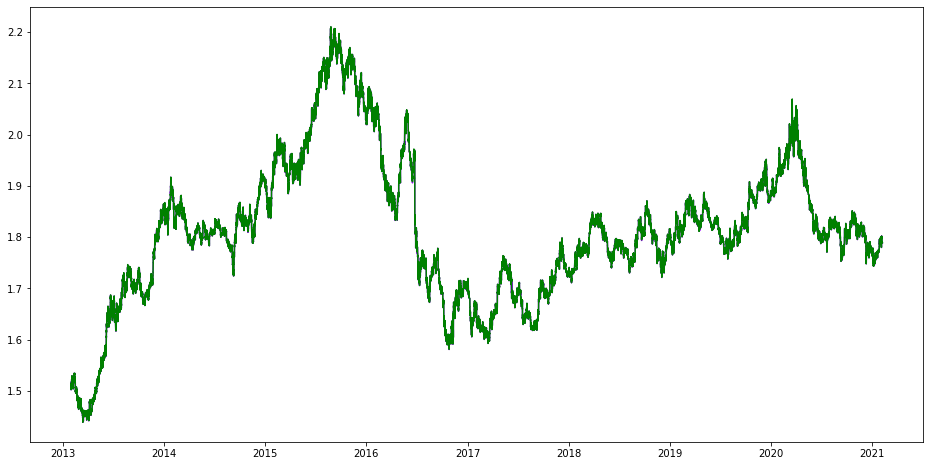

In [6]:
ax = gbpaud_close.plot()
ax = gbpaud_close_div.plot(ax=ax,color='g')

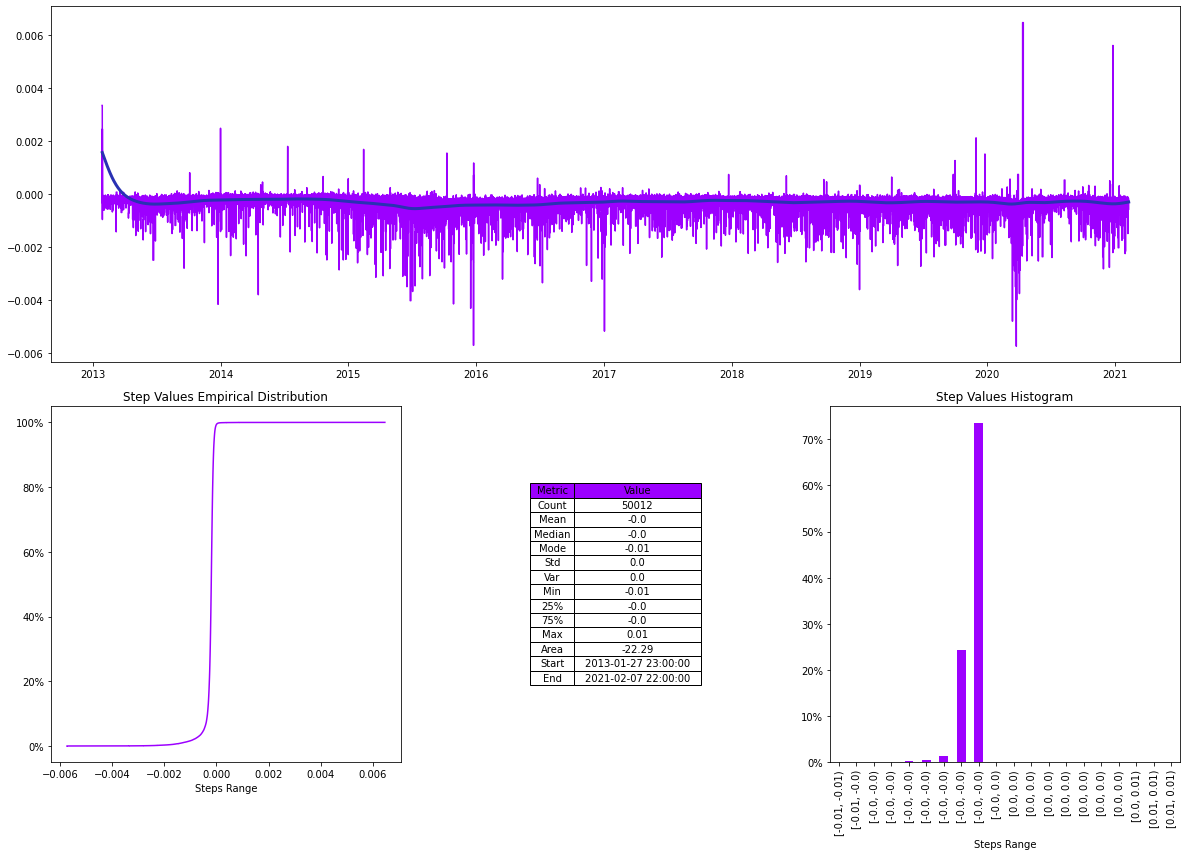

In [7]:
gbpaud_close_diff = gbpaud_close - gbpaud_close_div
gbpaud_close_diff.summary();

We can see that they are very close, but not quite the same, this is interesting, as we can also see how strongly they are correlated, but we can go one step further, we can shift each one forward and backward compare to the other to see if one appears to lead or lag the other. Hotstepper reuses the bitshift operator to shift a Steps object very easily.

In [8]:
gbpaud_close.correlation(gbpaud_close_div)

0.996277977934457

In [9]:
print(f'Correction with derived price shifted 1 hour forward, {gbpaud_close.correlation(gbpaud_close_div >> pd.Timedelta(hours=1))}')
print(f'Correction with derived price shifted 1 hour backwards, {gbpaud_close.correlation(gbpaud_close_div << pd.Timedelta(hours=1))}')

Correction with derived price shifted 1 hour forward, 0.9957581358580396
Correction with derived price shifted 1 hour backwards, 0.9965015268457172


Interesting, so based on the shifted and unshifted correlation scores, there appears to be a slight lead from the derived GBPAUD based on using the common USD. In order words, the GBPAUD derived from the ratio of GBPUSD and AUDUSD appears to lead or change before the published GBPAUD price, in this case, we have looked 1 hour earlier and found the correlation score is slightly higher compared to the unshifted and as partial confirmation, actually decreases if the shift is reversed, compared to the unshifted data sets. 